In [1]:
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

from matplotlib import gridspec

from sklearn.preprocessing import scale

from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

from torch.utils.data import Dataset

from sklearn.utils import shuffle
from scipy.special import softmax

from PIL import Image

from PIL import ImageDraw

from skimage import morphology

In [2]:
lang = 'ru'

In [3]:
folder_result = 'result'

In [4]:
plt.rcParams["font.family"] = 'Djvu Serif'

plt.rcParams['text.usetex'] = True

plt.rcParams['text.latex.unicode'] = True

In [5]:
plt.rcParams['text.latex.preamble'] = [r'\usepackage[utf8x]{inputenc}', 
                                       r'\usepackage[english,russian]{babel}', 
                                       r'\usepackage{amsmath}']

In [6]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = 36
plt.rcParams['ytick.labelsize'] = 36
plt.rcParams['legend.fontsize'] = 36
plt.rcParams['axes.titlesize']=36
plt.rcParams['axes.labelsize']=36
plt.rcParams['figure.figsize'] = (24.0, 12.0)
plt.rcParams['font.size'] = 40

In [7]:
color = ['black', 'gray', 'black', 'black', 'black']
marker = ['^', 's', 'v', 'D', 'P']

In [8]:
from TorchExperts import EachModelLinear, HyperModelNN, MixtureExpert, RegularizeModel

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Statement Picture

In [10]:
List_of_Data_Name = ['Data/1.csv', 'Data/2.csv', 'Data/3.csv']

List_of_Data = []

for NAME in List_of_Data_Name:
    data = pd.read_csv(NAME)
    x, y = np.array(data).T
    List_of_Data.append([x,y])

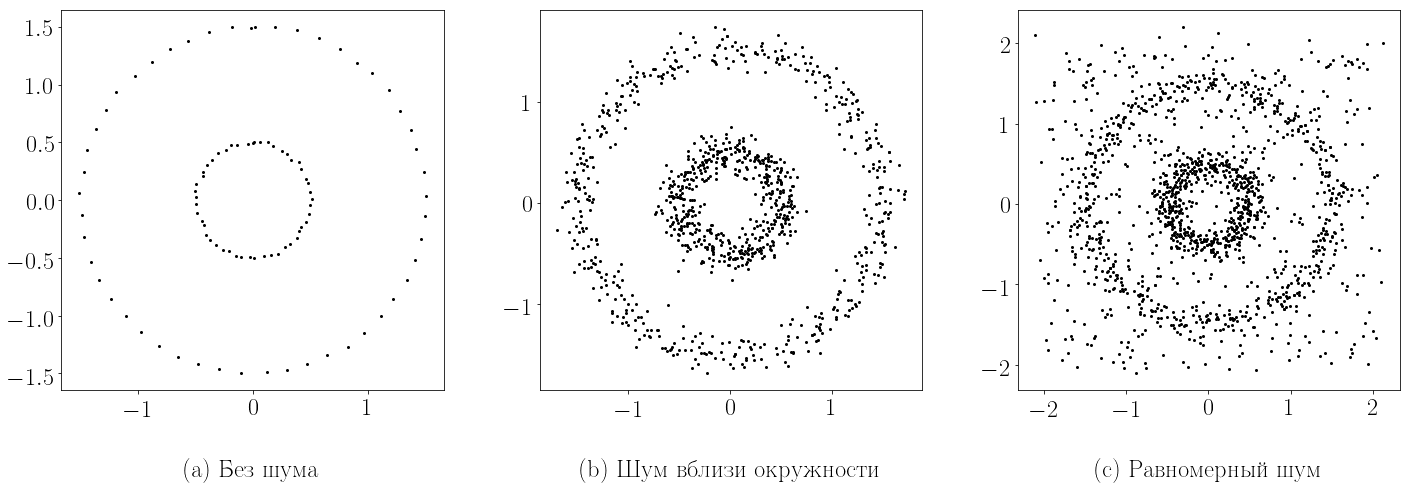

In [11]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (24.0, 7.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

t = np.linspace(0, 2*np.pi, 100)

colors = color


fig = plt.figure();

gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

ax = [] 
for k in range(3):
    ax.append(fig.add_subplot(gs[k]))

if lang == 'eng':
    cols = ['Without noise', 'Noise near circle', 'Uniform noise']
elif lang == 'ru':
    cols = ['Без шума', 'Шум вблизи окружности', 'Равномерный шум']

TITLE = ['(a)', '(b)', '(c)']

#------___1___------
for k in range(len(List_of_Data)):
    x, y = List_of_Data[k]

#     ax[k].set_xlabel('$x$')
#     ax[k].set_ylabel('$y$')
    
    _ = ax[k].plot(x, y, '.', color = colors[0])
    ax[k].set_title(TITLE[k] + ' ' + cols[k], y=-0.24)
        


plt.subplots_adjust(wspace=0.25, hspace=0.35)

plt.savefig('./' + folder_result+ '/statment.pdf', bbox_inches='tight')

plt.show()

## Computation experiment (Synthetick)

In [12]:
List_of_Data_Name = ['Data/1.csv', 'Data/2.csv', 'Data/3.csv']

List_of_Data = []

for NAME in List_of_Data_Name:
    data = pd.read_csv(NAME)
    x, y = np.array(data).T
    List_of_Data.append([x,y])

In [18]:
K = 2
n = 3

epoch = 50

In [19]:
List_of_Data_Prior = []
List_of_Prior_model = []

for k in range(len(List_of_Data)):

    x, y = List_of_Data[k]
    X = np.vstack([x, y, np.ones_like(x)]).T
    Y = x**2+y**2

    X_tr = torch.FloatTensor(X)
    Y_tr = torch.FloatTensor(Y).view([-1,1])

    LIST_A = [torch.Tensor([0.01, 0.01, 0.01]) for _ in range(K)]
    LIST_w = [torch.Tensor([[0], [0], [0.1]]), torch.Tensor([[0], [0], [2]])]

    LoM = []
    for k in range(K):
        LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.eye(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k], regul = False))

    HypPar = {'beta': 1}
    HpMd = HyperModelNN(input_dim = n, hidden_dim = 3, output_dim = K, device = device)

    model = MixtureExpert(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)
    model.fit(X_tr, Y_tr, epoch, progress = tqdm)

    idx = np.argmax(model.pZ.data.numpy(), axis = 1)
    
    List_of_Data_Prior.append(idx)
    List_of_Prior_model.append(model)



In [20]:
List_of_Data_Non_Prior = []
List_of_Non_Prior_model = []

for k in range(len(List_of_Data)):

    x, y = List_of_Data[k]
    X = np.vstack([2*x, 2*y, np.ones_like(x)]).T
    Y = x**2+y**2

    X_tr = torch.FloatTensor(X)
    Y_tr = torch.FloatTensor(Y).view([-1,1])
    
    LoM = []
    for k in range(K):
        LoM.append(EachModelLinear(input_dim = n, device = device))

    HypPar = {'beta': 1}
    HpMd = HyperModelNN(input_dim = n, hidden_dim = 3, output_dim = K, device = device)

    model = MixtureExpert(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)
    model.fit(X_tr, Y_tr, epoch, progress = tqdm)

    idx = np.argmax(model.pZ.data.numpy(), axis = 1)
    
    List_of_Data_Non_Prior.append(idx)
    List_of_Non_Prior_model.append(model)


In [21]:
List_of_Data_Regular_Prior = []
List_of_Regular_Prior_model = []

for k in range(len(List_of_Data)):

    x, y = List_of_Data[k]
    X = np.vstack([2*x, 2*y, np.ones_like(x)]).T
    Y = x**2+y**2

    X_tr = torch.FloatTensor(X)
    Y_tr = torch.FloatTensor(Y).view([-1,1])
    
    LIST_A = [torch.Tensor([0.01, 0.01, 0.01]) for _ in range(K)]
    LIST_w = [torch.Tensor([[0], [0], [0.1]]), torch.Tensor([[0], [0], [2]])]
    
    LoM = []
    for k in range(K):
        LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.eye(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k], regul = True))

    HypPar = {'beta': 1, 'alpha': 1e-20}
    HpMd = HyperModelNN(input_dim = n, hidden_dim = 3, output_dim = K, device = device)

    model = MixtureExpert(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, ListOfRegularizeModel = [RegularizeModel(ListOfModels = LoM)], device = device)
    model.fit(X_tr, Y_tr, epoch, progress = tqdm)

    idx = np.argmax(model.pZ.data.numpy(), axis = 1)
    
    List_of_Data_Regular_Prior.append(idx)
    List_of_Regular_Prior_model.append(model)



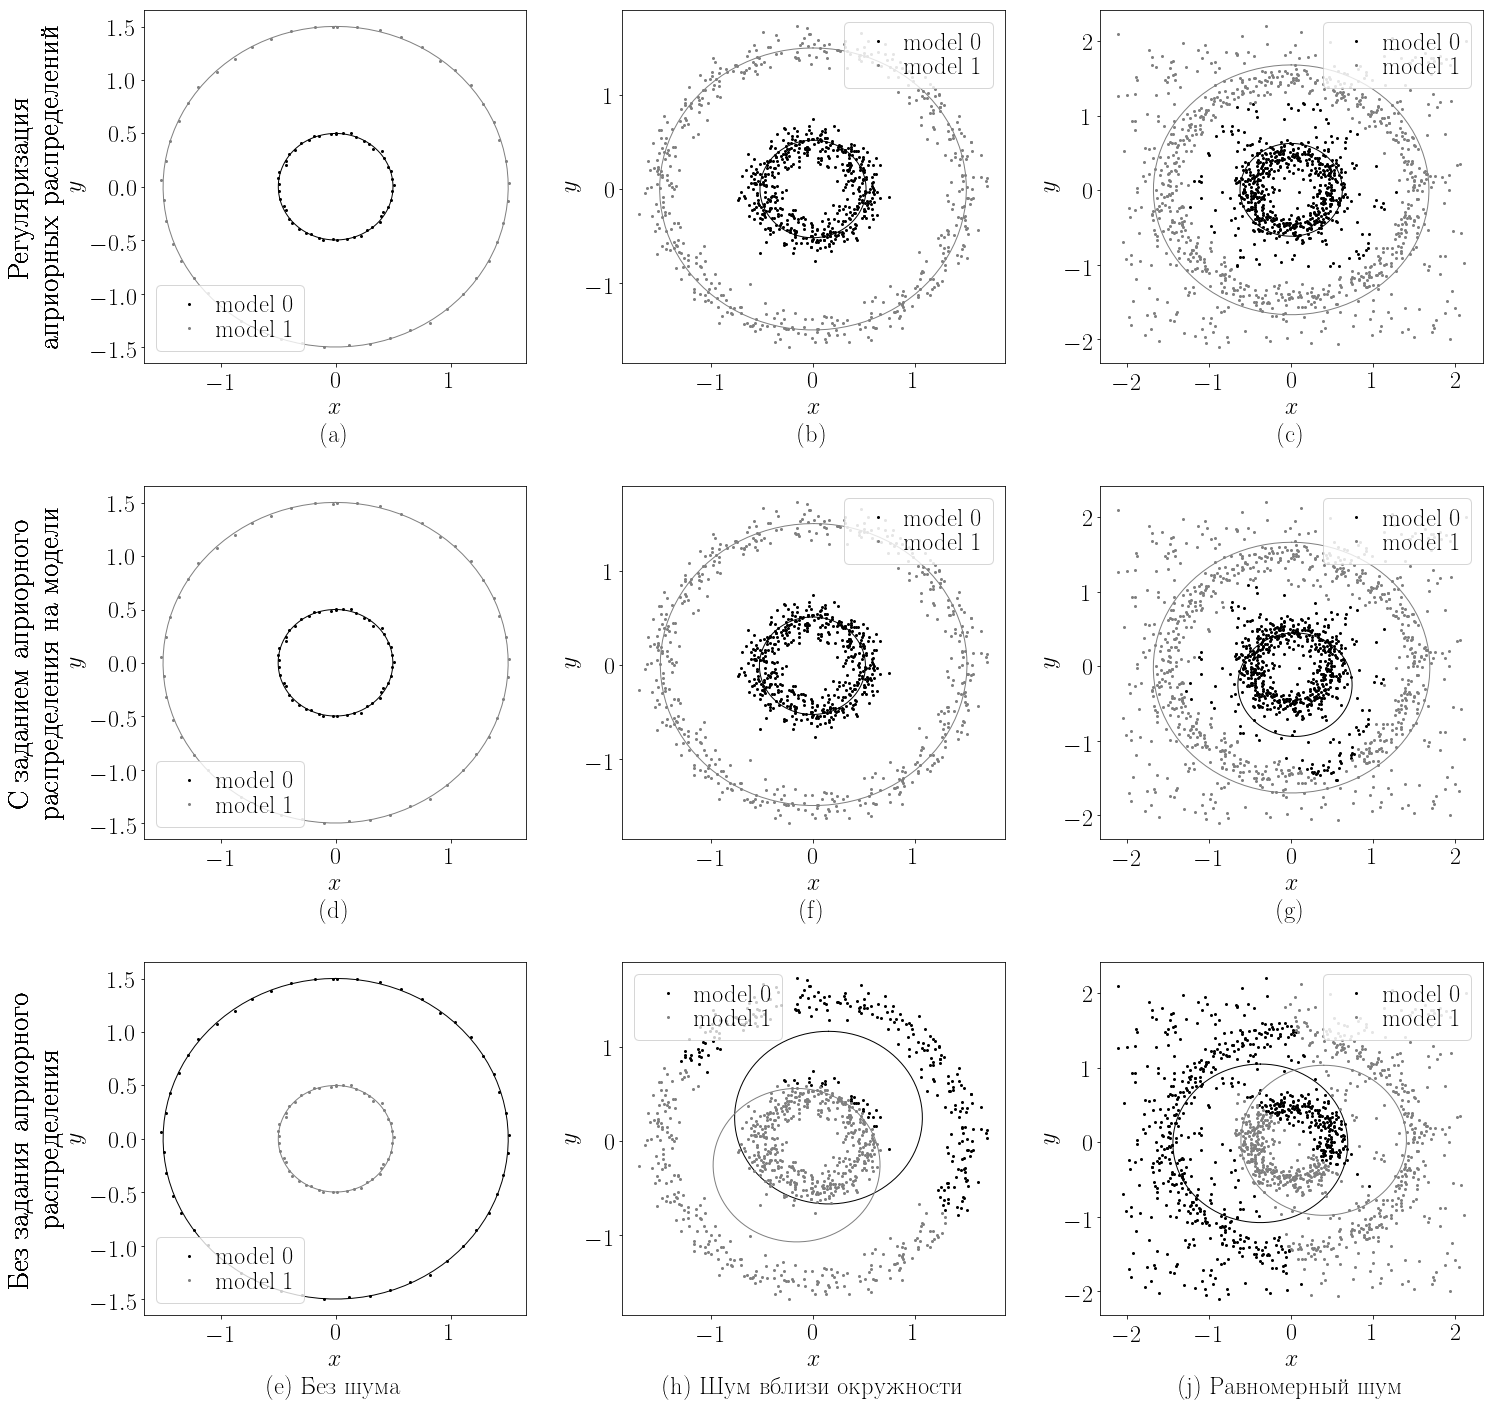

In [30]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (24.0, 24.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

t = np.linspace(0, 2*np.pi, 100)

colors = color


fig = plt.figure();

gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1, 1])

ax1 = [] 
for k in range(3):
    ax1.append(fig.add_subplot(gs[k]))
    
ax2 = [] 
for k in range(3, 6):
    ax2.append(fig.add_subplot(gs[k]))
    
ax3 = [] 
for k in range(6, 9):
    ax3.append(fig.add_subplot(gs[k]))
    
if lang == 'eng':
    cols = ['Without noise', 'Noise near circle', 'Uniform noise']
elif lang == 'ru':
    cols = ['Без шума', 'Шум вблизи окружности', 'Равномерный шум']
    
if lang == 'eng':
    rows = ['With prior regular', 'With prior', 'Without prior']
elif lang == 'ru':
    rows = ['Регуляризация\nаприорных распределений', 'C заданием априорного\nраспределения на модели', 'Без задания априорного\nраспределения']  

TITLE = ['(a)', '(b)', '(c)']
    
#------___1___------
for k in range(len(List_of_Data)):
    x, y = List_of_Data[k]
    idx = List_of_Data_Regular_Prior[k]
    
    model = List_of_Regular_Prior_model[k]
    TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])
    CIRCLE = np.zeros_like(TEMP)

    ax1[k].set_xlabel('$x$')
    ax1[k].set_ylabel('$y$')
    
    for i, param in enumerate(TEMP):
        x0, y0 = 0.5*param[:2]
        r = (param[2] + x0**2 + y0**2)**0.5
        CIRCLE[i] = x0, y0, r

    for i in np.unique(idx):
        _ = ax1[k].plot(x[idx == i], y[idx == i], '.', color = colors[i], label = 'model '+str(i))

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax1[k].plot(x_plot, y_plot, '-', color = colors[i])
        ax1[k].legend(loc = 'best')
        
        ax1[k].set_title(TITLE[k], y=-0.24)
        
        ax1[0].annotate(rows[0], xy=(0, 0.5), xytext=(-ax1[0].yaxis.labelpad - 24, 0),
                        xycoords=ax1[0].yaxis.label, textcoords='offset points',
                        size='large', ha='center', va='center', rotation=90)

TITLE = ['(d)', '(f)', '(g)']
        
#------___2___------
for k in range(len(List_of_Data)):
    x, y = List_of_Data[k]
    idx = List_of_Data_Prior[k]
    
    model = List_of_Prior_model[k]
    TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])
    CIRCLE = np.zeros_like(TEMP)

    ax2[k].set_xlabel('$x$')
    ax2[k].set_ylabel('$y$')
    
    for i, param in enumerate(TEMP):
        x0, y0 = 0.5*param[:2]
        r = (param[2] + x0**2 + y0**2)**0.5
        CIRCLE[i] = x0, y0, r

    for i in np.unique(idx):
        _ = ax2[k].plot(x[idx == i], y[idx == i], '.', color = colors[i], label = 'model '+str(i))

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax2[k].plot(x_plot, y_plot, '-', color = colors[i])
        ax2[k].legend(loc = 'best')
        
        ax2[k].set_title(TITLE[k], y=-0.24)
        
        ax2[0].annotate(rows[1], xy=(0, 0.5), xytext=(-ax2[0].yaxis.labelpad - 24, 0),
                        xycoords=ax2[0].yaxis.label, textcoords='offset points',
                        size='large', ha='center', va='center', rotation=90)

TITLE = ['(e)', '(h)', '(j)']
        
#------___3___------
for k in range(len(List_of_Data)):
    x, y = List_of_Data[k]
    idx = List_of_Data_Non_Prior[k]
    
    model = List_of_Non_Prior_model[k]
    TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])
    CIRCLE = np.zeros_like(TEMP)
    
    ax3[k].set_xlabel('$x$')
    ax3[k].set_ylabel('$y$')

    for i, param in enumerate(TEMP):
        x0, y0 = 0.5*param[:2]
        r = (param[2] + x0**2 + y0**2)**0.5
        CIRCLE[i] = x0, y0, r

    for i in np.unique(idx):
        _ = ax3[k].plot(x[idx == i], y[idx == i], '.', color = colors[i], label = 'model '+str(i))

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax3[k].plot(x_plot, y_plot, '-', color = colors[i])
        ax3[k].legend(loc = 'best')
        ax3[k].set_title(TITLE[k] + ' ' + cols[k], y=-0.24)
    
        ax3[0].annotate(rows[2], xy=(0, 0.5), xytext=(-ax3[0].yaxis.labelpad - 24, 0),
                        xycoords=ax3[0].yaxis.label, textcoords='offset points',
                        size='large', ha='center', va='center', rotation=90)
    
# plt.grid()

plt.subplots_adjust(wspace=0.25, hspace=0.35)

plt.savefig('./' + folder_result + '/experiment_sintetick.pdf', bbox_inches='tight')

plt.show()

# Picture in Experiment with real Data

In [10]:
image = Image.open('Picture/1.tif')

mask_1 = Image.open('Picture/1_mask_2.jpg').convert('L')
mask_1 = Image.fromarray((255*(np.array(mask_1) > 125)).astype(np.uint8))

In [11]:
x = np.array(np.where(np.array(mask_1) > 0)[1], dtype = np.float)
y = np.array(mask_1.size[0]-np.where(np.array(mask_1) > 0)[0], dtype = np.float)

x = scale(x)
y = scale(y)

x, y = shuffle(x, y, random_state = 0)

x = x[:200]
y = y[:200]

X = np.vstack([x, y, np.ones_like(x)]).T
Y = x**2+y**2

X_tr = torch.FloatTensor(X)
Y_tr = torch.FloatTensor(Y).view([-1,1])

X_tr.shape, Y_tr.shape

(torch.Size([200, 3]), torch.Size([200, 1]))

In [12]:
def extract_picture(model):
    TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])

    CIRCLE = np.zeros_like(TEMP)

    for i, param in enumerate(TEMP):
        x0, y0 = 0.5*param[:2]
        r = (param[2] + x0**2 + y0**2)**0.5
        CIRCLE[i] = x0, y0, r
        
    idx = np.argmax(model.pZ.data.numpy(), axis = 1)
    
    return CIRCLE, idx

In [13]:
K = 2
n = 3

epoch = 100

In [14]:
%%time

LIST_A = [torch.Tensor([0.1, 0.1, 0.1]) for _ in range(K)]
LIST_w = [torch.Tensor([[0.0], [0.0], [0.1]]), torch.Tensor([[0.0], [0.0], [2]])]


LoM = []
for k in range(K):
    LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.eye(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k], regul = False))

HypPar = {'beta': 1}

HpMd = HyperModelNN(input_dim = n, hidden_dim = 3, output_dim = K, device = device)

model = MixtureExpert(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)


List_of_step_Prior = []
for _ in tqdm(range(epoch)):
    model.fit(X_tr, Y_tr, 1, progress = None)
    List_of_step_Prior.append(extract_picture(model))



CPU times: user 52 s, sys: 1.53 s, total: 53.6 s
Wall time: 54 s


In [15]:
%%time

LIST_A = [torch.Tensor([0.1, 0.1, 0.1]) for _ in range(K)]
LIST_w = [torch.Tensor([[0.0], [0.0], [0.1]]), torch.Tensor([[0.0], [0.0], [2]])]


LoM = []
for k in range(K):
    LoM.append(EachModelLinear(input_dim = n, device = device, A = torch.eye(3)*LIST_A[k], w = torch.ones(3,1)*LIST_w[k], regul=True))

HypPar = {'beta': 1, 'alpha': 1e-15}

HpMd = HyperModelNN(input_dim = n, hidden_dim = 3, output_dim = K, device = device)

model = MixtureExpert(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, ListOfRegularizeModel = [RegularizeModel(ListOfModels = LoM)], device = device)

List_of_step_Prior_Regular = []
for _ in tqdm(range(epoch)):
    model.fit(X_tr, Y_tr, 1, progress = None)
    List_of_step_Prior_Regular.append(extract_picture(model))




CPU times: user 54.2 s, sys: 1.71 s, total: 55.9 s
Wall time: 56.9 s


In [ ]:
%%time

LoM = []
for k in range(K):
    LoM.append(EachModelLinear(input_dim = n, device = device))

HypPar = {'beta': 1}

HpMd = HyperModelNN(input_dim = n, hidden_dim = 3, output_dim = K, device = device)

model = MixtureExpert(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)


List_of_step_Not_Prior = []
for _ in tqdm(range(epoch)):
    model.fit(X_tr, Y_tr, 1, progress = None)
    List_of_step_Not_Prior.append(extract_picture(model))




In [ ]:
List_of_answers_comparing = [List_of_step_Not_Prior[-1], List_of_step_Prior[-1], List_of_step_Prior_Regular[-1]]

In [ ]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (24.0, 17.0)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

t = np.linspace(0, 2*np.pi, 100)

colors = color


fig = plt.figure();

gs = gridspec.GridSpec(2, 6, width_ratios=[1,1,1,1,1,1], height_ratios=[1,1])

ax1 = [] 
ax2 = []

ax1.append(fig.add_subplot(gs[0, 1:3]))
ax1.append(fig.add_subplot(gs[0, 3:5]))

ax2.append(fig.add_subplot(gs[1, 0:2]))
ax2.append(fig.add_subplot(gs[1, 2:4]))
ax2.append(fig.add_subplot(gs[1, 4:6]))
    
# ------------1------------
if lang == 'eng':
    cols = ['Real image', 'Binar image']
elif lang == 'ru':
    cols = ['Исходное изображение', 'Бинаризованное изображение']
    
TITLE = ['(a)', '(b)']

for k in range(len(ax1)):
    ax1[k].set_title(TITLE[k] + ' ' + cols[k], y=-0.2)
# Real image
k = 0
ax1[k].imshow(image)

# mask with iris circle
k = 1
ax1[k].plot(x, y, '.', color = color[0])

# ------------2------------
if lang == 'eng':
    cols = ['With prior regular', 'With prior', 'Without prior']
elif lang == 'ru':
    cols = ['Без задания априорного\nраспределения', 'C заданием априорного\nраспределения на модели', 'Регуляризация\nаприорных распределений']  

TITLE = ['(c)', '(d)', '(e)']

for k in range(len(ax2)):
    ax2[k].set_title(TITLE[k] + ' ' + cols[k], y=-0.24)
# Real image
for k in range(len(List_of_answers_comparing)):
    CIRCLE, idx = List_of_answers_comparing[k]
    for i in np.unique(idx):
        _ = ax2[k].plot(x[idx == i], y[idx == i], '.', color = colors[i], label = 'model '+str(i))

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax2[k].plot(x_plot, y_plot, '-', color = colors[i])
        ax2[k].legend(loc = 'best')



plt.subplots_adjust(wspace=0.4, hspace=0.35)
# plt.savefig('./' + folder_result + '/experiment_real_compare.pdf', bbox_inches='tight')

plt.show()

In [136]:
epochs = [1, 2, 3, 5, 10, 15]

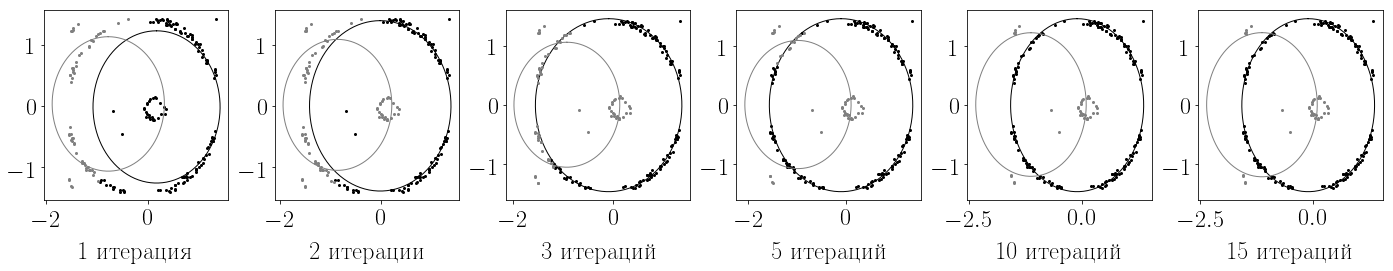

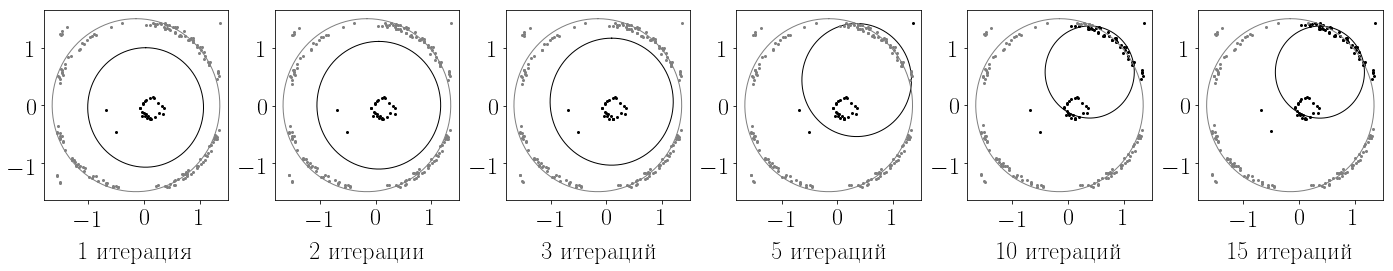

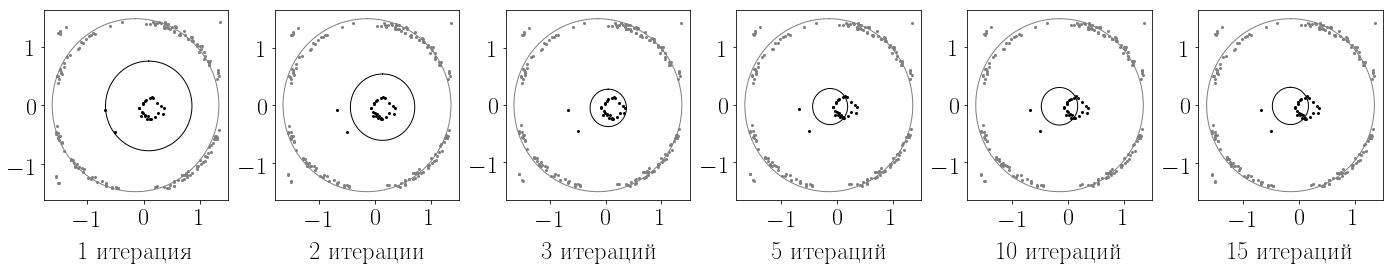

In [139]:
Text_size = 24

plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4
plt.rcParams['xtick.labelsize'] = Text_size
plt.rcParams['ytick.labelsize'] = Text_size
plt.rcParams['legend.fontsize'] = Text_size
plt.rcParams['axes.titlesize']=Text_size
plt.rcParams['axes.labelsize']=Text_size
plt.rcParams['figure.figsize'] = (24.0, 3.5)
plt.rcParams['font.size'] = Text_size
plt.rcParams["legend.labelspacing"] = 0.1
plt.rcParams["legend.handletextpad"] = 0.1
#################################################

t = np.linspace(0, 2*np.pi, 100)

colors = color

    
if lang == 'eng':
    rows = ['With prior regular', 'With prior', 'Without prior']
elif lang == 'ru':
    rows = ['Без задания априорного распределения', 'C заданием априорного распределения на модели', 'Регуляризация априорных распределений']  

if lang == 'eng':
    cols = [str(e) + 'epoch' for e in epochs]
elif lang == 'ru':
    cols = ['1 итерация', '2 итерации', '3 итераций', '5 итераций', '10 итераций', '15 итераций']


# -----------------1---------------------
fig = plt.figure();

gs = gridspec.GridSpec(1, len(epochs))

ax = []
for k in range(len(List_of_step)):
    ax.append(fig.add_subplot(gs[k]))
    
for k in range(len(ax)):
    ax[k].set_title(cols[k], y=-0.34)

List_of_step = [(List_of_step_Not_Prior[k - 1], k) for k in epochs]
for k in range(len(List_of_step)):
    (CIRCLE, idx), epoch = List_of_step[k]

    for i in np.unique(idx):
        _ = ax[k].plot(x[idx == i], y[idx == i], '.', color = colors[i])

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax[k].plot(x_plot, y_plot, '-', color = colors[i])


plt.subplots_adjust(wspace=0.25, hspace=0.35)
plt.savefig('./' + folder_result + '/experiment_real_not_prior.pdf', bbox_inches='tight')
plt.show()    
    
# -----------------2---------------------
fig = plt.figure();

gs = gridspec.GridSpec(1, len(epochs))

ax = []
for k in range(len(List_of_step)):
    ax.append(fig.add_subplot(gs[k]))

for k in range(len(ax)):
    ax[k].set_title(cols[k], y=-0.34)
    
List_of_step = [(List_of_step_Prior[k - 1], k) for k in epochs]
for k in range(len(List_of_step)):
    (CIRCLE, idx), epoch = List_of_step[k]

    for i in np.unique(idx):
        _ = ax[k].plot(x[idx == i], y[idx == i], '.', color = colors[i])

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax[k].plot(x_plot, y_plot, '-', color = colors[i])

plt.subplots_adjust(wspace=0.25, hspace=0.35)
plt.savefig('./' + folder_result + '/experiment_real_prior.pdf', bbox_inches='tight')
plt.show()

# -----------------3---------------------
fig = plt.figure();

gs = gridspec.GridSpec(1, len(epochs))

ax = []
for k in range(len(List_of_step)):
    ax.append(fig.add_subplot(gs[k]))

for k in range(len(ax)):
    ax[k].set_title(cols[k], y=-0.34)
    
List_of_step = [(List_of_step_Prior_Regular[k - 1], k) for k in epochs]
for k in range(len(List_of_step)):
    (CIRCLE, idx), epoch = List_of_step[k]

    for i in np.unique(idx):
        _ = ax[k].plot(x[idx == i], y[idx == i], '.', color = colors[i])

        x0, y0, r = CIRCLE[i]
        x_plot = x0 + r*np.sin(t)
        y_plot = y0 + r*np.cos(t)

        _ = ax[k].plot(x_plot, y_plot, '-', color = colors[i])

plt.subplots_adjust(wspace=0.25, hspace=0.35)
plt.savefig('./' + folder_result + '/experiment_real_regular.pdf', bbox_inches='tight')
plt.show()